In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import umap


import joblib
from itertools import product
# optional, for progress bars
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import wilcoxon

def get_bootstrap_aucs(y_true, y_pred, bootstrap_iters=100):
    rng = np.random.RandomState(seed=42)
    idxs = list(range(y_pred.shape[0]))
    
    bootstrap_aucs = []
    for _ in range(bootstrap_iters):
        try:
            curr_idxs = rng.choice(idxs, size=len(idxs), replace=True)
            bootstrap_aucs.append(roc_auc_score(y_true[curr_idxs], y_pred[curr_idxs],
                                                multi_class='ovr', average='macro'))
        except ValueError:
            pass

    return np.median(bootstrap_aucs), bootstrap_aucs
    
def get_p_values(all_aucs):
    all_aucs = np.vstack(all_aucs)
    median_aucs = np.median(all_aucs, -1)
    second_best_idx, best_idx = median_aucs.argsort()[-2:] 
    p_val = wilcoxon(all_aucs[best_idx], all_aucs[second_best_idx])[1]
    return p_val, (second_best_idx, best_idx)

def pval_to_str(p_val):
    if p_val < 0.0001:
        p_val = 'p<0.0001'
        p_val = '***'
    else:
        p_val = f'p={p_val:.4f}'
    return p_val

def darken_hex(hex_color, factor=0.5):
    # Ensure the factor is between 0 and 1
    factor = max(0, min(factor, 1))

    # Remove the hash symbol if present
    hex_color = hex_color.lstrip('#')

    # Convert hex to RGB
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

    # Darken the RGB values by multiplying by the factor
    darkened_rgb = tuple(int(c * factor) for c in rgb)

    # Convert the RGB values back to hex
    darkened_hex = '#{:02x}{:02x}{:02x}'.format(*darkened_rgb)

    return darkened_hex




In [2]:
dftrain = pd.read_csv('/mnt/e/IDRiD_B_DiseaseGrading/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
dftest = pd.read_csv('/mnt/e/IDRiD_B_DiseaseGrading/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')

target_col = 'Retinopathy grade'
dataset = 'Diabetic Retinopathy (IDRiD → BRSET) - Points correspond to unseen BRSET dataset'
target_cols = list(range(5)) + [-1]

name_X_list = [
    ('RETFound-MEH', 
     '/home/justin/RETFound_MAE/IRID_Train_RETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/BRSET_RETFound_Feature_latent.npy'),
    ('DERETFound', 
     '/home/justin/RETFound_MAE/IRID_Train_DERETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/BRSET_DERETFound_Feature_latent.npy'),
    ('RETFound-Green', 
     'IRID_Train_X_ours.npy',
     'X_ours_brset.npy'),
]
dfbr = pd.read_csv('/mnt/c/Users/Justin/Desktop/labels.csv')
dfbr['Retinopathy grade'] = dfbr['DR_ICDR']
br_diab_mask = dfbr.diabetes=='yes'
dfbr = dfbr[br_diab_mask].copy().reset_index()

target_to_colour = {
    'Normal': '#5bc0de',   # Light blue (neutral/safe)
    'Grade 1': '#66c266',  # Medium-light green
    'Grade 2': '#ffcc00',  # Golden yellow
    'Grade 3': '#ff6600',  # Orange-red
    'Grade 4': '#990000',  # Dark red
    'No/Mild': None,
}


target_int_to_name = {_: f"Grade {_}" for _ in target_cols}
target_int_to_name[0] = 'Normal'
target_int_to_name[-1] = 'No/Mild'


models = ['RETFound-MEH', 'DERETFound', 'RETFound-Green']
colors = ['#ff595e', '#ffca3a', '#8ac926']  # Colors for models

  0%|          | 0/3 [00:00<?, ?it/s]

RETFound-MEH
DERETFound
RETFound-Green


Normal vs Rest         Grade 1 vs Rest         Grade 2 vs Rest  \
                        Logit     KNN           Logit     KNN           Logit   
RETFound-MEH           0.6124  0.4862          0.5177  0.5683          0.6514   
DERETFound             0.5672  0.4586          0.4811  0.5640          0.6208   
RETFound-Green         0.7856  0.7318          0.6491  0.5510          0.5585   

                       Grade 3 vs Rest         Grade 4 vs Rest          \
                   KNN           Logit     KNN           Logit     KNN   
RETFound-MEH    0.5794          0.6445  0.4980          0.6386  0.4087   
DERETFound      0.5365          0.6198  0.5240          0.5782  0.4421   
RETFound-Green  0.5385          0.7803  0.7169          0.8606  0.6743   

               No/Mild vs Rest          
                         Logit     KNN  
RETFound-MEH            0.6657  0.5031  
DERETFound              0.6197  0.4959  
RETFound-Green          0.8533  0.7825

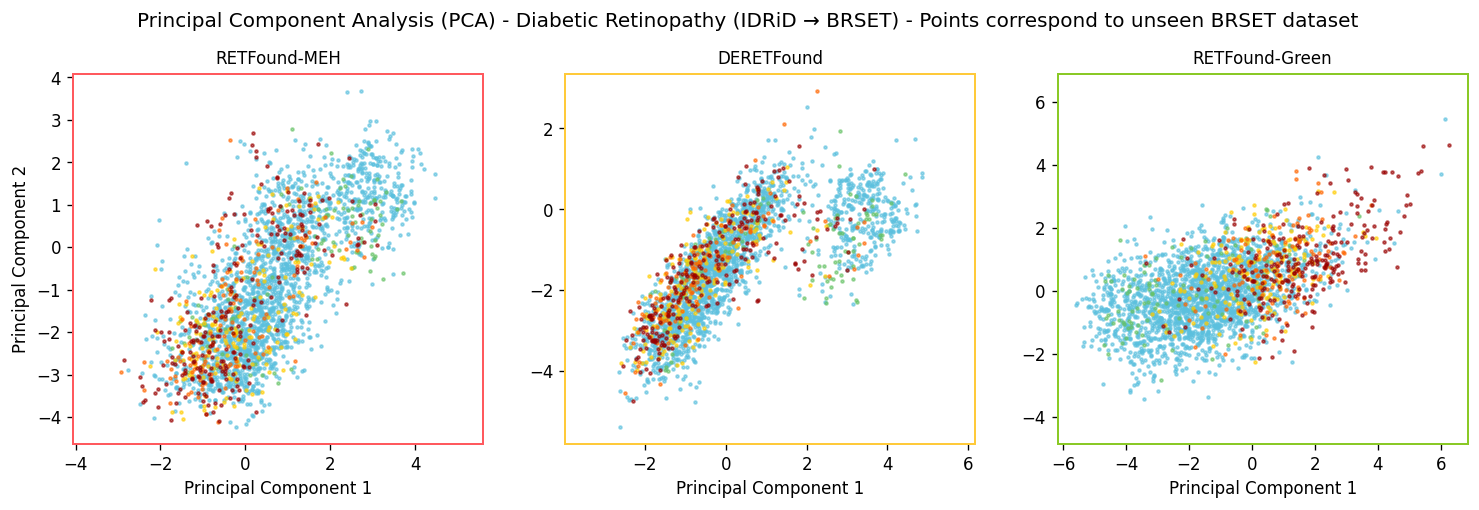

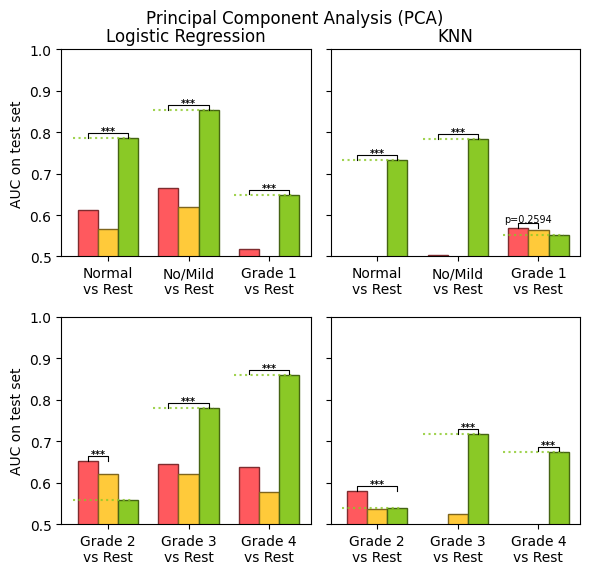

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=120)

projection_method_name = 'Principal Component Analysis (PCA)'
dim_name = 'Principal Component'
projector = PCA(n_components=2)

results_df = pd.DataFrame()
bootstrap_results_dict = {}

for n_idx, (name, X_train_fname, X_test_fname) in enumerate(tqdm(name_X_list)):
    print(name)
    np.random.seed(42)
    X_train = np.load(X_train_fname)
    X_test = np.load(X_test_fname)[br_diab_mask]

    y_train = dftrain[target_col]
    y_test = dfbr[target_col]

    embedding = projector.fit_transform(X_train)
    embedding_test = projector.transform(X_test)

    logit = LogisticRegression(max_iter=10_000, random_state=42)
    knn = KNeighborsClassifier(n_jobs=-1)

    for target in target_cols:
        if target >= 0:
            curr_y_train = y_train.apply(lambda x: x==target)
            curr_y_test = y_test.apply(lambda x: x==target)
        elif target==-1:
            # https://pubmed.ncbi.nlm.nih.gov/13129861/
            curr_y_train = y_train.apply(lambda x: x>=2)
            curr_y_test = y_test.apply(lambda x: x>=2)
        else:
            raise ValueError
        
        logit.fit(embedding, curr_y_train)
        logit_preds = logit.predict_proba(embedding_test)[:,1]
        logit_median_auc, logit_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, logit_preds)

        knn.fit(embedding, curr_y_train)
        knn_preds = knn.predict_proba(embedding_test)[:,1]
        knn_median_auc, knn_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, knn_preds)

        target = target_int_to_name[target]
        
        results_df.loc[name, f'{target} vs rest - Logit'] = logit_median_auc
        results_df.loc[name, f'{target} vs rest - KNN'] = knn_median_auc

        bootstrap_results_dict[f'{name}-{target}-Logit'] = logit_bootstrap_aucs
        bootstrap_results_dict[f'{name}-{target}-KNN'] = knn_bootstrap_aucs


    for c_idx, c in enumerate(np.unique(y_train)):
        curr_mask = y_test==c
        
        ax[n_idx].scatter(
            embedding_test[:, 0][curr_mask],
            embedding_test[:, 1][curr_mask],
            alpha=0.6,
            s=3,
            label=target_int_to_name[c],
            c=target_to_colour[target_int_to_name[c]],
        )
        ax[n_idx].set_aspect('equal', 'datalim')
        ax[n_idx].set_title(name, fontsize='medium')
        ax[n_idx].set_xlabel(f'{dim_name} 1')
        if n_idx==0:
            ax[n_idx].set_ylabel(f'{dim_name} 2')

        for spine in ax[n_idx].spines.values():
            spine.set_edgecolor(colors[n_idx])
            spine.set_linewidth(1.2)

targets = [f'{k} vs Rest' for k in target_to_colour.keys()]
classifiers = ['Logit', 'KNN']
results_df.columns = pd.MultiIndex.from_product([targets, classifiers])

display(results_df.round(4))
plt.suptitle(f'{projection_method_name} - {dataset}', fontsize='large', y=1.01)
plt.show()


targets_row1 = ['Normal vs Rest', 'No/Mild vs Rest', 'Grade 1 vs Rest']
targets_row2 = ['Grade 2 vs Rest', 'Grade 3 vs Rest', 'Grade 4 vs Rest']
classifiers = ['Logit', 'KNN']

fig, ax = plt.subplots(2, 2, figsize=(6, 6))  # Side by side plots
(ax1, ax2, ax3, ax4) = ax.flat

for targets, axes in [(targets_row1, (ax1, ax2)), (targets_row2, (ax3, ax4))]:
    x = np.arange(len(targets))
    width = 0.25
    
    for ax, classifier in zip(axes, classifiers):
        for i, model in enumerate(models):
            values = [results_df.loc[model, (target, classifier)] for target in targets]
            locs = x + i*width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] - 2.75 * width
                    _right = locs[_idx] + 0.25 * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [bootstrap_results_dict[f'{name}-{target_str}-{classifier}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()
            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val+0.001, best_val+0.012, best_val+0.012, best_val+0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val<0.0001 else 0.01
            ax.text((start_loc+end_loc)/2, best_val +text_loc_height_offset, pval_to_str(p_val), ha='center', fontsize='x-small', 
                    weight=None  if not p_val<0.05 else 'bold')

            
        
        ax.set_xticks(x + width)
        targets_display = [_.replace(' vs', '\nvs') for _ in  targets]
        ax.set_xticklabels(targets_display, rotation=0, ha='center')
        ax.set_ylim(0.5, 1)


ax1.set_title('Logistic Regression')
ax2.set_title('KNN')
ax1.set_ylabel('AUC on test set')
ax3.set_ylabel('AUC on test set')
ax2.set_yticklabels([])
ax4.set_yticklabels([])

plt.suptitle(f'{projection_method_name}', y=0.95, fontsize='large')
plt.tight_layout()
plt.show()


  0%|          | 0/3 [00:00<?, ?it/s]

RETFound-MEH
DERETFound
RETFound-Green


Normal vs Rest         Grade 1 vs Rest         Grade 2 vs Rest  \
                        Logit     KNN           Logit     KNN           Logit   
RETFound-MEH           0.5890  0.5782          0.5835  0.5619          0.6295   
DERETFound             0.5599  0.5404          0.4057  0.5155          0.6356   
RETFound-Green         0.6790  0.5949          0.6115  0.5758          0.6101   

                       Grade 3 vs Rest         Grade 4 vs Rest          \
                   KNN           Logit     KNN           Logit     KNN   
RETFound-MEH    0.5487          0.6328  0.5905          0.5859  0.6241   
DERETFound      0.5392          0.4355  0.5374          0.5246  0.6800   
RETFound-Green  0.5376          0.6704  0.6546          0.6475  0.6163   

               No/Mild vs Rest          
                         Logit     KNN  
RETFound-MEH            0.6332  0.6225  
DERETFound              0.6018  0.6080  
RETFound-Green          0.7154  0.6373

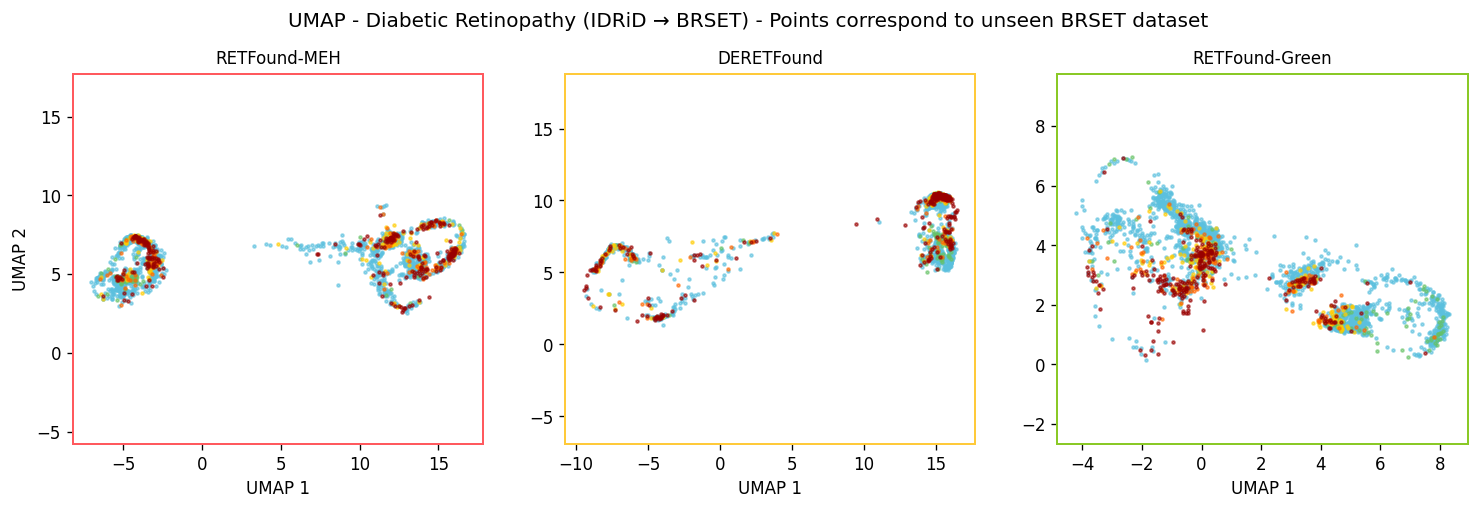

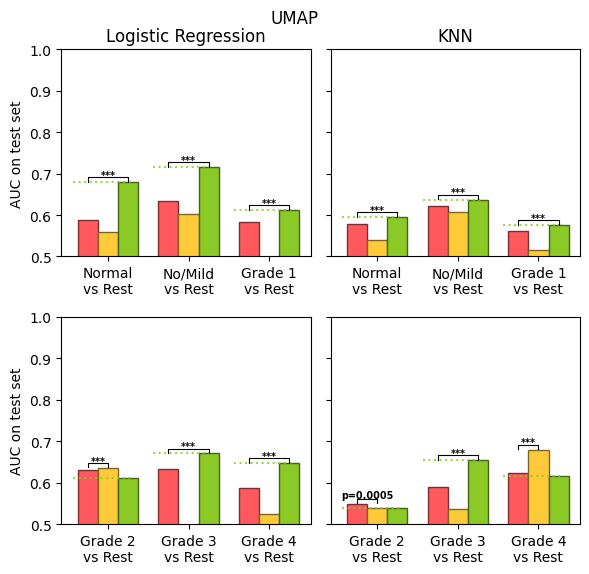

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=120)

projection_method_name = 'UMAP'
dim_name = 'UMAP'

results_df = pd.DataFrame()
bootstrap_results_dict = {}

for n_idx, (name, X_train_fname, X_test_fname) in enumerate(tqdm(name_X_list)):
    print(name)
    np.random.seed(42)
    X_train = np.load(X_train_fname)
    X_test = np.load(X_test_fname)[br_diab_mask]

    y_train = dftrain[target_col]
    y_test = dfbr[target_col]

    projector = umap.UMAP(metric='cosine', random_state=42, n_jobs=1)

    embedding = projector.fit_transform(X_train)
    embedding_test = projector.transform(X_test)

    logit = LogisticRegression(max_iter=10_000, random_state=42)
    knn = KNeighborsClassifier(n_jobs=-1)

    for target in target_cols:
        if target >= 0:
            curr_y_train = y_train.apply(lambda x: x==target)
            curr_y_test = y_test.apply(lambda x: x==target)
        elif target==-1:
            # https://pubmed.ncbi.nlm.nih.gov/13129861/
            curr_y_train = y_train.apply(lambda x: x>=2)
            curr_y_test = y_test.apply(lambda x: x>=2)
        else:
            raise ValueError
        
        logit.fit(embedding, curr_y_train)
        logit_preds = logit.predict_proba(embedding_test)[:,1]
        logit_median_auc, logit_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, logit_preds)

        knn.fit(embedding, curr_y_train)
        knn_preds = knn.predict_proba(embedding_test)[:,1]
        knn_median_auc, knn_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, knn_preds)

        target = target_int_to_name[target]
        
        results_df.loc[name, f'{target} vs rest - Logit'] = logit_median_auc
        results_df.loc[name, f'{target} vs rest - KNN'] = knn_median_auc

        bootstrap_results_dict[f'{name}-{target}-Logit'] = logit_bootstrap_aucs
        bootstrap_results_dict[f'{name}-{target}-KNN'] = knn_bootstrap_aucs


    for c_idx, c in enumerate(np.unique(y_train)):
        curr_mask = y_test==c
        
        ax[n_idx].scatter(
            embedding_test[:, 0][curr_mask],
            embedding_test[:, 1][curr_mask],
            alpha=0.6,
            s=3,
            label=target_int_to_name[c],
            c=target_to_colour[target_int_to_name[c]],
        )
        ax[n_idx].set_aspect('equal', 'datalim')
        ax[n_idx].set_title(name, fontsize='medium')
        ax[n_idx].set_xlabel(f'{dim_name} 1')
        if n_idx==0:
            ax[n_idx].set_ylabel(f'{dim_name} 2')

        for spine in ax[n_idx].spines.values():
            spine.set_edgecolor(colors[n_idx])
            spine.set_linewidth(1.2)

targets = [f'{k} vs Rest' for k in target_to_colour.keys()]
classifiers = ['Logit', 'KNN']
results_df.columns = pd.MultiIndex.from_product([targets, classifiers])

display(results_df.round(4))
plt.suptitle(f'{projection_method_name} - {dataset}', fontsize='large', y=1.01)
plt.show()


targets_row1 = ['Normal vs Rest', 'No/Mild vs Rest', 'Grade 1 vs Rest']
targets_row2 = ['Grade 2 vs Rest', 'Grade 3 vs Rest', 'Grade 4 vs Rest']
classifiers = ['Logit', 'KNN']

fig, ax = plt.subplots(2, 2, figsize=(6, 6))  # Side by side plots
(ax1, ax2, ax3, ax4) = ax.flat

for targets, axes in [(targets_row1, (ax1, ax2)), (targets_row2, (ax3, ax4))]:
    x = np.arange(len(targets))
    width = 0.25
    
    for ax, classifier in zip(axes, classifiers):
        for i, model in enumerate(models):
            values = [results_df.loc[model, (target, classifier)] for target in targets]
            locs = x + i*width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] - 2.75 * width
                    _right = locs[_idx] + 0.25 * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [bootstrap_results_dict[f'{name}-{target_str}-{classifier}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()
            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val+0.001, best_val+0.012, best_val+0.012, best_val+0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val<0.0001 else 0.01
            ax.text((start_loc+end_loc)/2, best_val +text_loc_height_offset, pval_to_str(p_val), ha='center', fontsize='x-small', 
                    weight=None  if not p_val<0.05 else 'bold')

            
        
        ax.set_xticks(x + width)
        targets_display = [_.replace(' vs', '\nvs') for _ in  targets]
        ax.set_xticklabels(targets_display, rotation=0, ha='center')
        ax.set_ylim(0.5, 1)


ax1.set_title('Logistic Regression')
ax2.set_title('KNN')
ax1.set_ylabel('AUC on test set')
ax3.set_ylabel('AUC on test set')
ax2.set_yticklabels([])
ax4.set_yticklabels([])

plt.suptitle(f'{projection_method_name}', y=0.95, fontsize='large')
plt.tight_layout()
plt.show()


In [5]:
dftrain = pd.read_csv('/mnt/e/IDRiD_B_DiseaseGrading/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
dftest = pd.read_csv('/mnt/e/IDRiD_B_DiseaseGrading/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')

target_col = 'Retinopathy grade'
dataset = 'Diabetic Retinopathy (BRSET → IDRiD) - Points correspond to unseen IDRiD train set'
target_cols = list(range(5)) + [-1]

name_X_list = [
    ('RETFound-MEH', 
     '/home/justin/RETFound_MAE/IRID_Train_RETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/BRSET_RETFound_Feature_latent.npy'),
    ('DERETFound', 
     '/home/justin/RETFound_MAE/IRID_Train_DERETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/BRSET_DERETFound_Feature_latent.npy'),
    ('RETFound-Green', 
     'IRID_Train_X_ours.npy',
     'X_ours_brset.npy'),
]
dfbr = pd.read_csv('/mnt/c/Users/Justin/Desktop/labels.csv')
dfbr['Retinopathy grade'] = dfbr['DR_ICDR']
br_diab_mask = dfbr.diabetes=='yes'
dfbr = dfbr[br_diab_mask].copy().reset_index()

target_to_colour = {
    'Normal': '#5bc0de',   # Light blue (neutral/safe)
    'Grade 1': '#66c266',  # Medium-light green
    'Grade 2': '#ffcc00',  # Golden yellow
    'Grade 3': '#ff6600',  # Orange-red
    'Grade 4': '#990000',  # Dark red
    'No/Mild': None,
}


target_int_to_name = {_: f"Grade {_}" for _ in target_cols}
target_int_to_name[0] = 'Normal'
target_int_to_name[-1] = 'No/Mild'


models = ['RETFound-MEH', 'DERETFound', 'RETFound-Green']
colors = ['#ff595e', '#ffca3a', '#8ac926']  # Colors for models

  0%|          | 0/3 [00:00<?, ?it/s]

RETFound-MEH
DERETFound
RETFound-Green


Normal vs Rest         Grade 1 vs Rest         Grade 2 vs Rest  \
                        Logit     KNN           Logit     KNN           Logit   
RETFound-MEH           0.7761  0.4376          0.4883  0.4288          0.6413   
DERETFound             0.7452  0.4944          0.6505  0.4749          0.6502   
RETFound-Green         0.8726  0.7701          0.6502  0.5090          0.6196   

                       Grade 3 vs Rest         Grade 4 vs Rest          \
                   KNN           Logit     KNN           Logit     KNN   
RETFound-MEH    0.5677          0.6405  0.5000          0.6164  0.5095   
DERETFound      0.5510          0.6556  0.5020          0.6453  0.5026   
RETFound-Green  0.5082          0.7735  0.3685          0.8443  0.6722   

               No/Mild vs Rest          
                         Logit     KNN  
RETFound-MEH            0.7566  0.4934  
DERETFound              0.7757  0.5228  
RETFound-Green          0.9123  0.7789

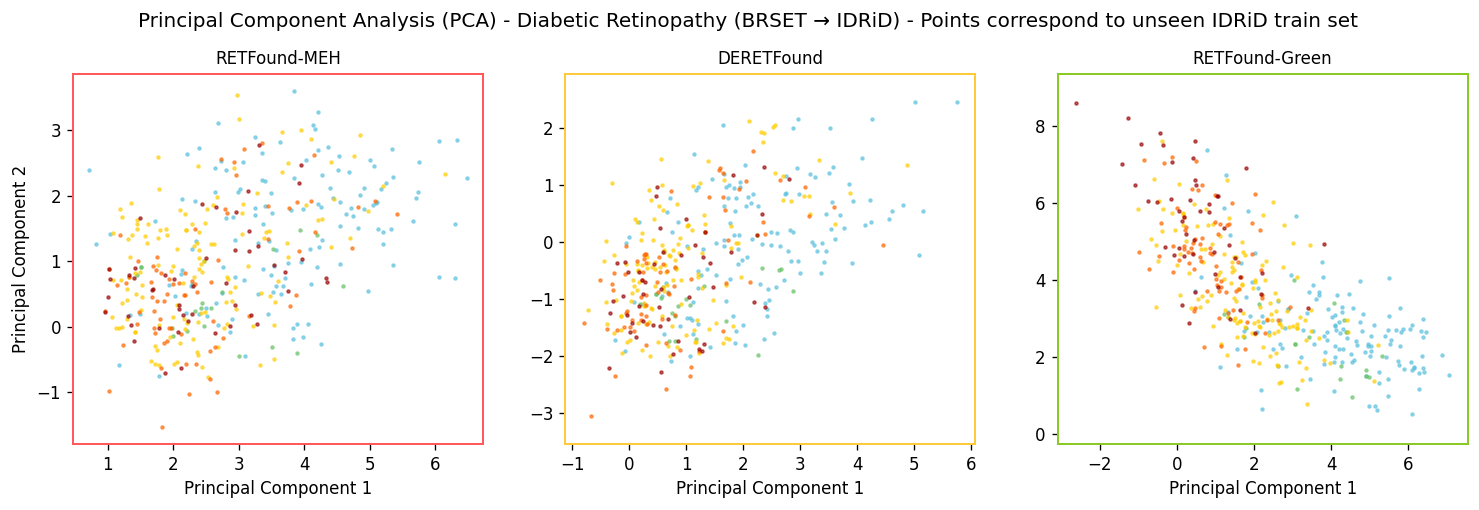

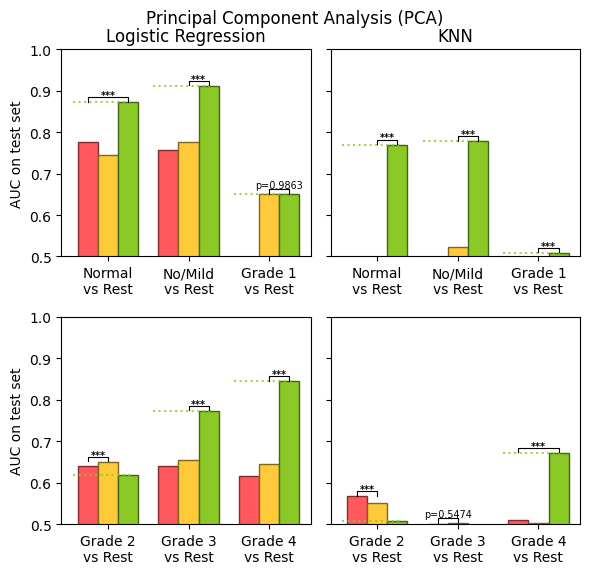

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=120)

projection_method_name = 'Principal Component Analysis (PCA)'
dim_name = 'Principal Component'
projector = PCA(n_components=2)

results_df = pd.DataFrame()
bootstrap_results_dict = {}

for n_idx, (name, X_train_fname, X_test_fname) in enumerate(tqdm(name_X_list)):
    print(name)
    np.random.seed(42)
    # swapped
    X_test = np.load(X_train_fname)
    X_train = np.load(X_test_fname)[br_diab_mask]

    y_test = dftrain[target_col]
    y_train = dfbr[target_col]

    embedding = projector.fit_transform(X_train)
    embedding_test = projector.transform(X_test)

    logit = LogisticRegression(max_iter=10_000, random_state=42)
    knn = KNeighborsClassifier(n_jobs=-1)

    for target in target_cols:
        if target >= 0:
            curr_y_train = y_train.apply(lambda x: x==target)
            curr_y_test = y_test.apply(lambda x: x==target)
        elif target==-1:
            # https://pubmed.ncbi.nlm.nih.gov/13129861/
            curr_y_train = y_train.apply(lambda x: x>=2)
            curr_y_test = y_test.apply(lambda x: x>=2)
        else:
            raise ValueError
        
        logit.fit(embedding, curr_y_train)
        logit_preds = logit.predict_proba(embedding_test)[:,1]
        logit_median_auc, logit_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, logit_preds)

        knn.fit(embedding, curr_y_train)
        knn_preds = knn.predict_proba(embedding_test)[:,1]
        knn_median_auc, knn_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, knn_preds)

        target = target_int_to_name[target]
        
        results_df.loc[name, f'{target} vs rest - Logit'] = logit_median_auc
        results_df.loc[name, f'{target} vs rest - KNN'] = knn_median_auc

        bootstrap_results_dict[f'{name}-{target}-Logit'] = logit_bootstrap_aucs
        bootstrap_results_dict[f'{name}-{target}-KNN'] = knn_bootstrap_aucs


    for c_idx, c in enumerate(np.unique(y_train)):
        curr_mask = y_test==c
        
        ax[n_idx].scatter(
            embedding_test[:, 0][curr_mask],
            embedding_test[:, 1][curr_mask],
            alpha=0.6,
            s=3,
            label=target_int_to_name[c],
            c=target_to_colour[target_int_to_name[c]],
        )
        ax[n_idx].set_aspect('equal', 'datalim')
        ax[n_idx].set_title(name, fontsize='medium')
        ax[n_idx].set_xlabel(f'{dim_name} 1')
        if n_idx==0:
            ax[n_idx].set_ylabel(f'{dim_name} 2')

        for spine in ax[n_idx].spines.values():
            spine.set_edgecolor(colors[n_idx])
            spine.set_linewidth(1.2)

targets = [f'{k} vs Rest' for k in target_to_colour.keys()]
classifiers = ['Logit', 'KNN']
results_df.columns = pd.MultiIndex.from_product([targets, classifiers])

display(results_df.round(4))
plt.suptitle(f'{projection_method_name} - {dataset}', fontsize='large', y=1.01)
plt.show()


targets_row1 = ['Normal vs Rest', 'No/Mild vs Rest', 'Grade 1 vs Rest']
targets_row2 = ['Grade 2 vs Rest', 'Grade 3 vs Rest', 'Grade 4 vs Rest']
classifiers = ['Logit', 'KNN']

fig, ax = plt.subplots(2, 2, figsize=(6, 6))  # Side by side plots
(ax1, ax2, ax3, ax4) = ax.flat

for targets, axes in [(targets_row1, (ax1, ax2)), (targets_row2, (ax3, ax4))]:
    x = np.arange(len(targets))
    width = 0.25
    
    for ax, classifier in zip(axes, classifiers):
        for i, model in enumerate(models):
            values = [results_df.loc[model, (target, classifier)] for target in targets]
            locs = x + i*width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] - 2.75 * width
                    _right = locs[_idx] + 0.25 * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [bootstrap_results_dict[f'{name}-{target_str}-{classifier}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()
            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val+0.001, best_val+0.012, best_val+0.012, best_val+0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val<0.0001 else 0.01
            ax.text((start_loc+end_loc)/2, best_val +text_loc_height_offset, pval_to_str(p_val), ha='center', fontsize='x-small', 
                    weight=None  if not p_val<0.05 else 'bold')

            
        
        ax.set_xticks(x + width)
        targets_display = [_.replace(' vs', '\nvs') for _ in  targets]
        ax.set_xticklabels(targets_display, rotation=0, ha='center')
        ax.set_ylim(0.5, 1)


ax1.set_title('Logistic Regression')
ax2.set_title('KNN')
ax1.set_ylabel('AUC on test set')
ax3.set_ylabel('AUC on test set')
ax2.set_yticklabels([])
ax4.set_yticklabels([])

plt.suptitle(f'{projection_method_name}', y=0.95, fontsize='large')
plt.tight_layout()
plt.show()


  0%|          | 0/3 [00:00<?, ?it/s]

RETFound-MEH
DERETFound
RETFound-Green


Normal vs Rest         Grade 1 vs Rest         Grade 2 vs Rest  \
                        Logit     KNN           Logit     KNN           Logit   
RETFound-MEH           0.6937  0.6397          0.5629  0.4344          0.6067   
DERETFound             0.7463  0.6520          0.3630  0.5169          0.5639   
RETFound-Green         0.4415  0.7839          0.6959  0.5603          0.4742   

                       Grade 3 vs Rest         Grade 4 vs Rest          \
                   KNN           Logit     KNN           Logit     KNN   
RETFound-MEH    0.5374          0.5894  0.5096          0.6207  0.5728   
DERETFound      0.5212          0.6143  0.4742          0.6343  0.5885   
RETFound-Green  0.5353          0.6172  0.6292          0.6873  0.6994   

               No/Mild vs Rest          
                         Logit     KNN  
RETFound-MEH            0.7054  0.6144  
DERETFound              0.6696  0.6763  
RETFound-Green          0.6276  0.7883

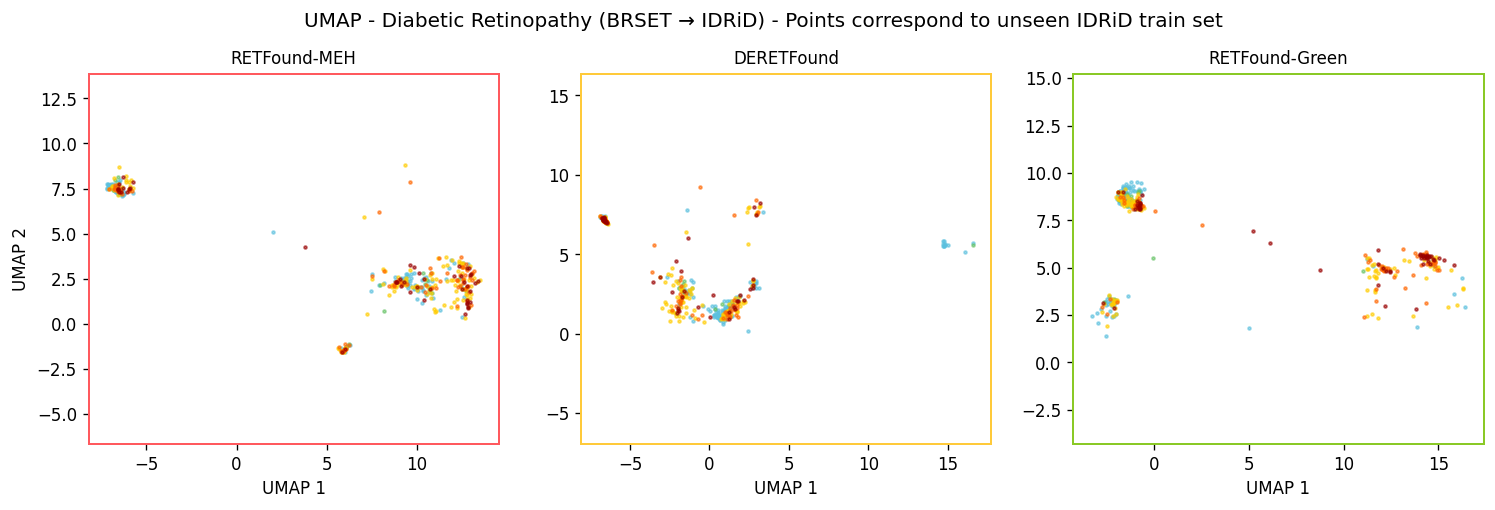

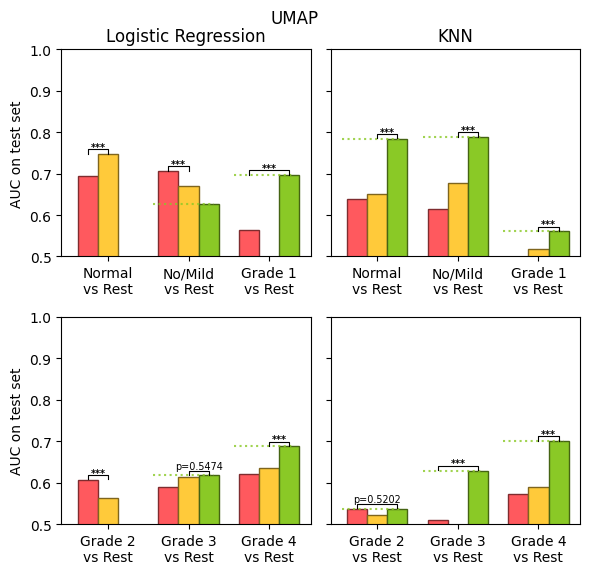

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=120)

projection_method_name = 'UMAP'
dim_name = 'UMAP'

results_df = pd.DataFrame()
bootstrap_results_dict = {}

for n_idx, (name, X_train_fname, X_test_fname) in enumerate(tqdm(name_X_list)):
    print(name)
    np.random.seed(42)
    # swapped
    X_test = np.load(X_train_fname)
    X_train = np.load(X_test_fname)[br_diab_mask]

    y_test = dftrain[target_col]
    y_train = dfbr[target_col]

    projector = umap.UMAP(metric='cosine', random_state=42, n_jobs=1)

    embedding = projector.fit_transform(X_train)
    embedding_test = projector.transform(X_test)

    logit = LogisticRegression(max_iter=10_000, random_state=42)
    knn = KNeighborsClassifier(n_jobs=-1)

    for target in target_cols:
        if target >= 0:
            curr_y_train = y_train.apply(lambda x: x==target)
            curr_y_test = y_test.apply(lambda x: x==target)
        elif target==-1:
            # https://pubmed.ncbi.nlm.nih.gov/13129861/
            curr_y_train = y_train.apply(lambda x: x>=2)
            curr_y_test = y_test.apply(lambda x: x>=2)
        else:
            raise ValueError
        
        logit.fit(embedding, curr_y_train)
        logit_preds = logit.predict_proba(embedding_test)[:,1]
        logit_median_auc, logit_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, logit_preds)

        knn.fit(embedding, curr_y_train)
        knn_preds = knn.predict_proba(embedding_test)[:,1]
        knn_median_auc, knn_bootstrap_aucs = get_bootstrap_aucs(curr_y_test, knn_preds)

        target = target_int_to_name[target]
        
        results_df.loc[name, f'{target} vs rest - Logit'] = logit_median_auc
        results_df.loc[name, f'{target} vs rest - KNN'] = knn_median_auc

        bootstrap_results_dict[f'{name}-{target}-Logit'] = logit_bootstrap_aucs
        bootstrap_results_dict[f'{name}-{target}-KNN'] = knn_bootstrap_aucs


    for c_idx, c in enumerate(np.unique(y_train)):
        curr_mask = y_test==c
        
        ax[n_idx].scatter(
            embedding_test[:, 0][curr_mask],
            embedding_test[:, 1][curr_mask],
            alpha=0.6,
            s=3,
            label=target_int_to_name[c],
            c=target_to_colour[target_int_to_name[c]],
        )
        ax[n_idx].set_aspect('equal', 'datalim')
        ax[n_idx].set_title(name, fontsize='medium')
        ax[n_idx].set_xlabel(f'{dim_name} 1')
        if n_idx==0:
            ax[n_idx].set_ylabel(f'{dim_name} 2')

        for spine in ax[n_idx].spines.values():
            spine.set_edgecolor(colors[n_idx])
            spine.set_linewidth(1.2)

targets = [f'{k} vs Rest' for k in target_to_colour.keys()]
classifiers = ['Logit', 'KNN']
results_df.columns = pd.MultiIndex.from_product([targets, classifiers])

display(results_df.round(4))
plt.suptitle(f'{projection_method_name} - {dataset}', fontsize='large', y=1.01)
plt.show()


targets_row1 = ['Normal vs Rest', 'No/Mild vs Rest', 'Grade 1 vs Rest']
targets_row2 = ['Grade 2 vs Rest', 'Grade 3 vs Rest', 'Grade 4 vs Rest']
classifiers = ['Logit', 'KNN']

fig, ax = plt.subplots(2, 2, figsize=(6, 6))  # Side by side plots
(ax1, ax2, ax3, ax4) = ax.flat

for targets, axes in [(targets_row1, (ax1, ax2)), (targets_row2, (ax3, ax4))]:
    x = np.arange(len(targets))
    width = 0.25
    
    for ax, classifier in zip(axes, classifiers):
        for i, model in enumerate(models):
            values = [results_df.loc[model, (target, classifier)] for target in targets]
            locs = x + i*width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] - 2.75 * width
                    _right = locs[_idx] + 0.25 * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [bootstrap_results_dict[f'{name}-{target_str}-{classifier}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()
            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val+0.001, best_val+0.012, best_val+0.012, best_val+0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val<0.0001 else 0.01
            ax.text((start_loc+end_loc)/2, best_val +text_loc_height_offset, pval_to_str(p_val), ha='center', fontsize='x-small', 
                    weight=None  if not p_val<0.05 else 'bold')

            
        
        ax.set_xticks(x + width)
        targets_display = [_.replace(' vs', '\nvs') for _ in  targets]
        ax.set_xticklabels(targets_display, rotation=0, ha='center')
        ax.set_ylim(0.5, 1)


ax1.set_title('Logistic Regression')
ax2.set_title('KNN')
ax1.set_ylabel('AUC on test set')
ax3.set_ylabel('AUC on test set')
ax2.set_yticklabels([])
ax4.set_yticklabels([])

plt.suptitle(f'{projection_method_name}', y=0.95, fontsize='large')
plt.tight_layout()
plt.show()
